In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [79]:
df_products = pd.read_csv('data/processed_prod_data.csv')


/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_31827/2061017201.py:1: DtypeWarning:

Columns (15,16,17,18,19,20,28) have mixed types. Specify dtype option on import or set low_memory=False.



to-do

- what exactly is a single product in the dataset


- dist of ratings

- dist of product reviews 
- dist of loves 
- dist of product_names per brand_name
- dist of amount, by measurement
- boxplot of amount, by measurement and swatch group size 
- count of swatch group sizes


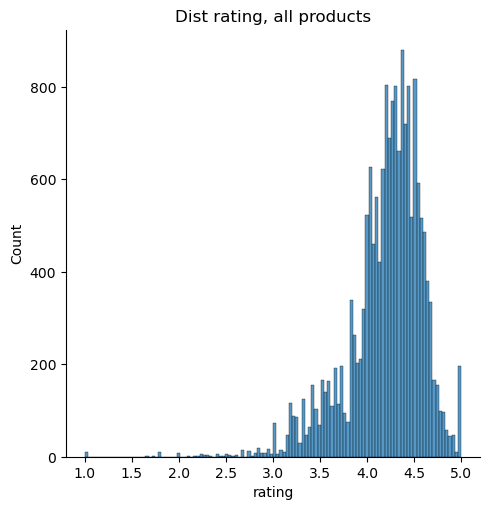

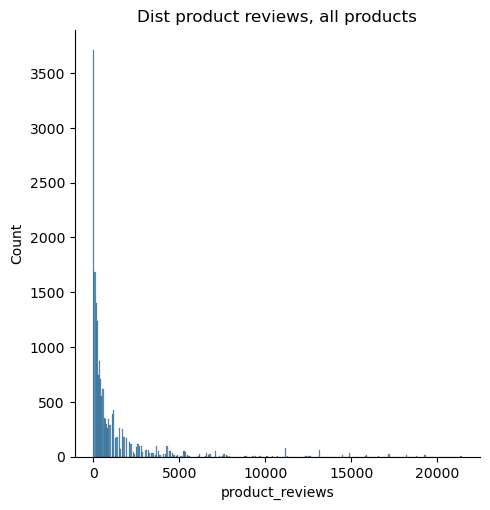

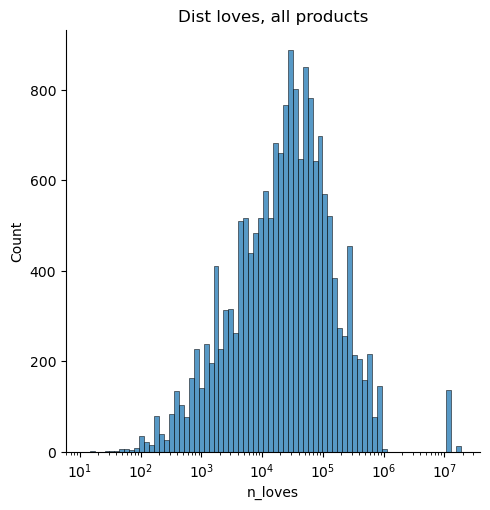

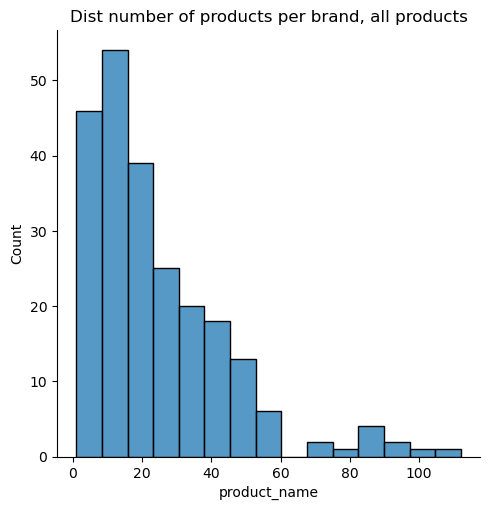

,brand_name,product_name
184,sephora collection,112
122,kérastase,98
24,bumble and bumble,94
133,mac cosmetics,91
210,tom ford,89


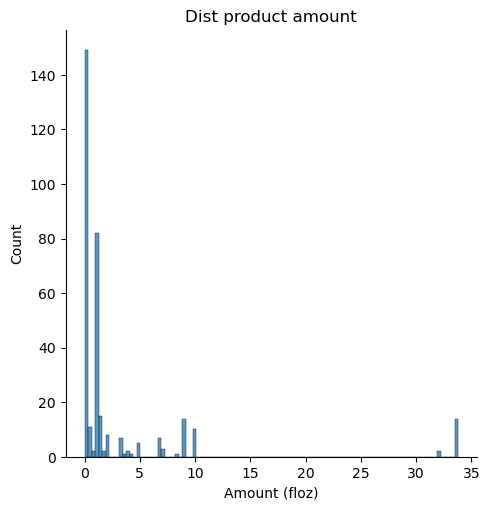

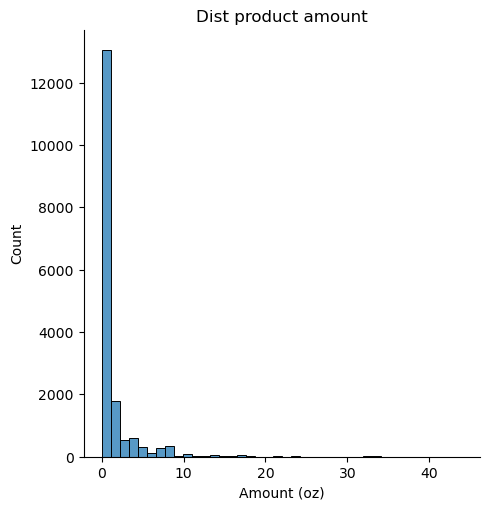

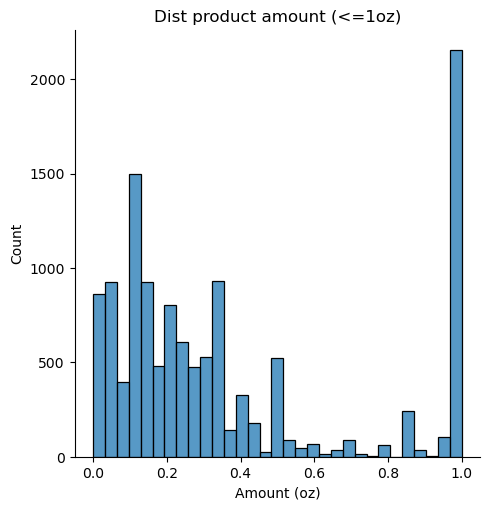

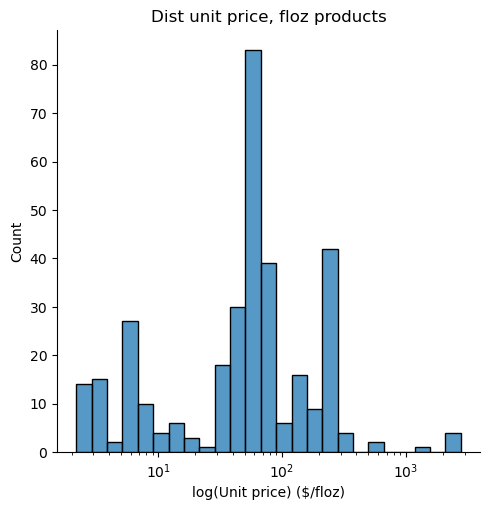

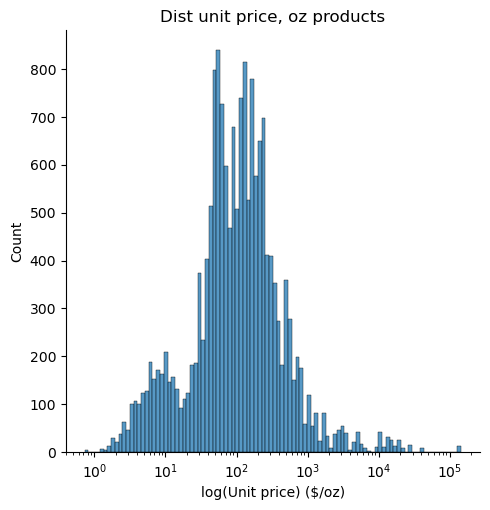

In [80]:

sns.displot(data=df_products, x="rating")
plt.title('Dist rating, all products')
plt.show()

sns.displot(data=df_products, x="product_reviews")#, log_scale=True)
plt.title('Dist product reviews, all products')
plt.show()

sns.displot(data=df_products, x="n_loves", log_scale=True)
plt.title('Dist loves, all products')
plt.show()

prods_per_brand = df_products.groupby('brand_name', as_index=False)['product_name'].nunique()
sns.displot(data=prods_per_brand, x="product_name")
plt.title('Dist number of products per brand, all products')
plt.show()
display(prods_per_brand.sort_values(by='product_name', ascending=False).head())

sns.displot(data=df_products[df_products['unit_a']=='floz'], x="amount_a")
plt.title('Dist product amount')
plt.xlabel('Amount (floz)')
plt.show()

sns.displot(data=df_products[df_products['unit_a']=='oz'], x="amount_a", bins=40)
plt.title('Dist product amount')
plt.xlabel('Amount (oz)')
plt.show()

sns.displot(data=df_products[(df_products['unit_a']=='oz') & (df_products['amount_a']<=1)], x="amount_a")
plt.title('Dist product amount (<=1oz)')
plt.xlabel('Amount (oz)')
plt.show()

sns.displot(data=df_products[df_products['unit_a']=='floz'], x="unit_price",log_scale=True)
plt.title('Dist unit price, floz products')
plt.xlabel('log(Unit price) ($/floz)')
plt.show()

sns.displot(data=df_products[df_products['unit_a']=='oz'], x="unit_price", log_scale=True)
plt.title('Dist unit price, oz products')
plt.xlabel('log(Unit price) ($/oz)')
plt.show()

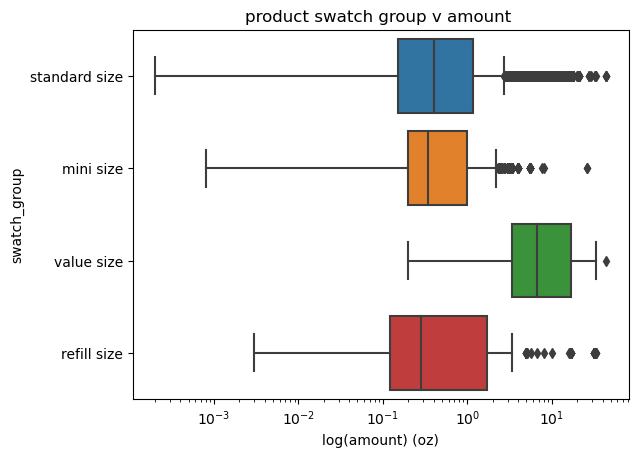

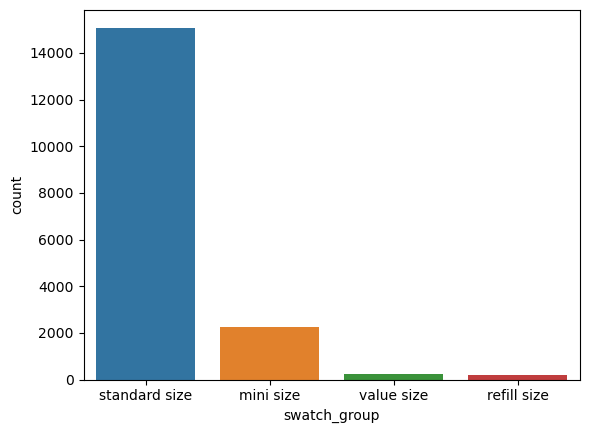

In [81]:


sns.boxplot(data=df_products[(df_products['unit_a']=='oz')], x="amount_a", y="swatch_group")
plt.xscale('log')
plt.xlabel('log(amount) (oz)' )
plt.title('product swatch group v amount ')
plt.show()


sns.countplot(x=df_products["swatch_group"])
plt.show()


In [82]:
df_products.groupby(['unit_a','unit_b'])['internal_product_id'].count().head(100)

unit_a  unit_b
floz    g             1
        ml          335
oz      g          6073
        ml        11368
Name: internal_product_id, dtype: int64

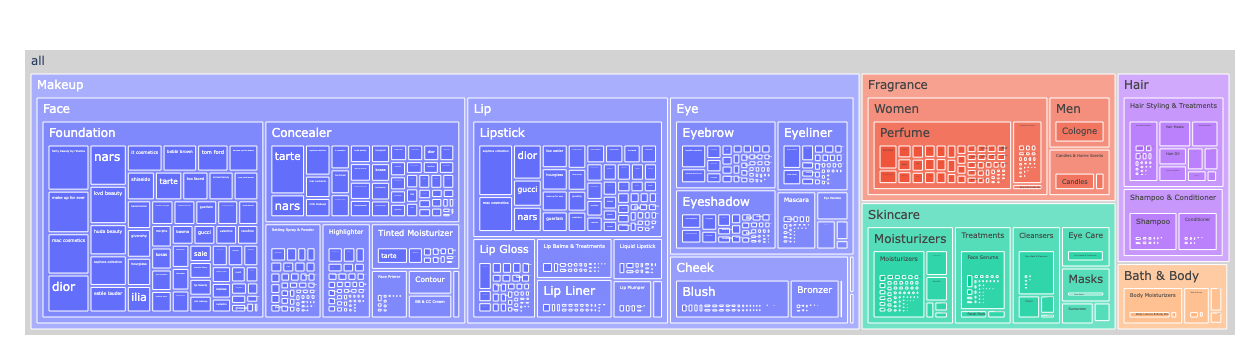

In [83]:

df_products_tree = df_products.groupby(['lvl_0_cat', 'lvl_1_cat', 'lvl_2_cat','brand_name'], as_index=False)['internal_product_id'].count()
fig = px.treemap(df_products_tree, path=[px.Constant("all"), 'lvl_0_cat', 'lvl_1_cat', 'lvl_2_cat','brand_name'], values='internal_product_id')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

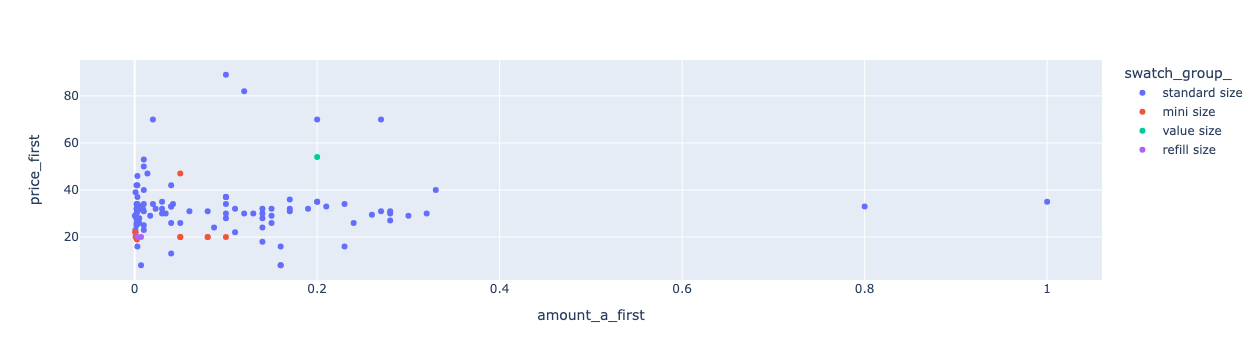

In [84]:
fig = px.scatter(solid_products[solid_products['lvl_2_cat_first']=='Eyebrow'], x="amount_a_first", y="price_first", color="swatch_group_", hover_data=['brand_name_', 'product_name_'])
fig.show()

# what is a single product ?

[brand_name, product_name, swatch_group, size, price]
 - if price is used and only some options are on sale, this would create duplicates
 - if price is left out of group-by, what is the best way to aggregate? max?
 
 - aggregated values like rating, product_reviews, n_loves should be same for all options of product?


https://www.sephora.com/ca/en/product/P434104?skuId=2407302

as each swatch group is clicked, sku in url changes
- a single product can have multiple skus depending on colour
- a single product can have multiple skus depending on size 


### Comparing standard with mini sizes

In [86]:
df = df_products.groupby(['product_name', 'brand_name', 'swatch_group','unit_a','amount_a'], as_index=False).agg({
    'price':'max',
    'internal_product_id':'nunique',
    'rating':'max',
    'product_reviews':'max',
    'n_loves':'max',
    'lvl_0_cat':'first',
    'lvl_1_cat':'first',
    'lvl_2_cat':'first',
    'sku':'unique',
    'amount_b':'first',
    'unit_b':'first'
})

In [54]:
solid_products = df_products[(df_products['unit_a']=='oz')]

solid_products = solid_products.groupby(['brand_name','product_name','swatch_group'], as_index=False).agg({
    'sku':['unique','count'],
    'rating':'first',
    'product_reviews':'first',
    'price':['first','unique','nunique'],
    'size':'first',
    'name':'nunique',
    'amount_a':'first',
    'unit_a':'first',
    'amount_b':'first',
    'unit_b':'first',
    'lvl_0_cat':'first',
    'lvl_1_cat':'first',
    'lvl_2_cat':'first'
})
solid_products.columns = ['_'.join(x) for x in solid_products.columns]


In [55]:
solid_products['unit_price'] = solid_products['amount_a_first']/solid_products['price_first']#.hist()

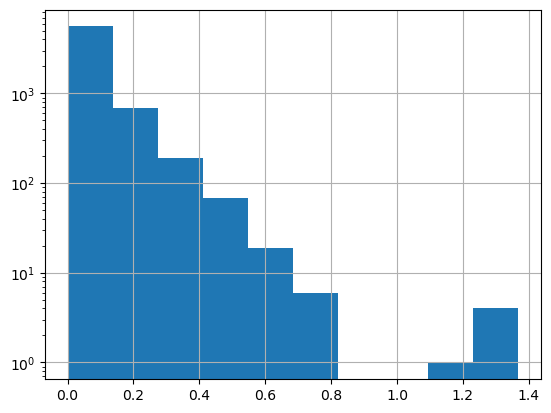

In [56]:
solid_products['unit_price'].hist()
plt.yscale('log')

In [57]:
# solid_products.sort_values(by='unit_price',ascending=False)

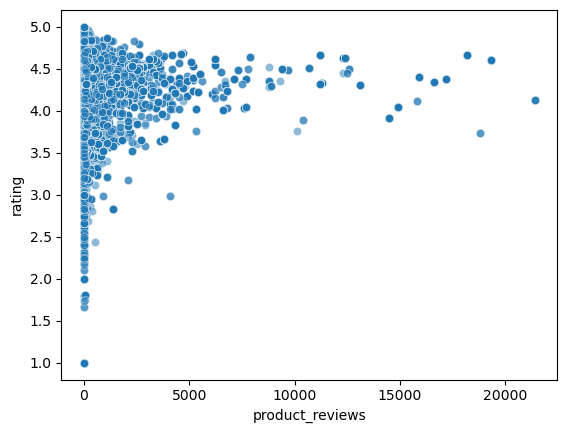

,internal_product_id,url,product_name,brand_name,options,rating,product_reviews,ingredients,n_loves,categories,...,url_params,product_multiplier,multiplier,amount_a,unit_a,amount_b,unit_b,misc_info,swatch_details,unit_price
7470,3621,https://www.sephora.com/ca/en/product/better-t...,better than sex volumizing & lengthening water...,too faced,"[{'swatch_group': 'Standard size', 'size': Non...",2.9823,4100.0,"Isododecane, Paraffin, VP/Eicosene Copolymer, ...",116700.0,"['Makeup', 'Eye', 'Mascara']",...,"{'skuId': ['1809193'], 'icid2': ['products gri...",NaN,NaN,0.27,oz,8.0,ml,NaN,standard size,137.037037
7471,3621,https://www.sephora.com/ca/en/product/better-t...,better than sex volumizing & lengthening water...,too faced,"[{'swatch_group': 'Standard size', 'size': Non...",2.9823,4100.0,"Isododecane, Paraffin, VP/Eicosene Copolymer, ...",116700.0,"['Makeup', 'Eye', 'Mascara']",...,"{'skuId': ['1809193'], 'icid2': ['products gri...",NaN,NaN,0.17,oz,5.0,ml,NaN,mini size,123.529412


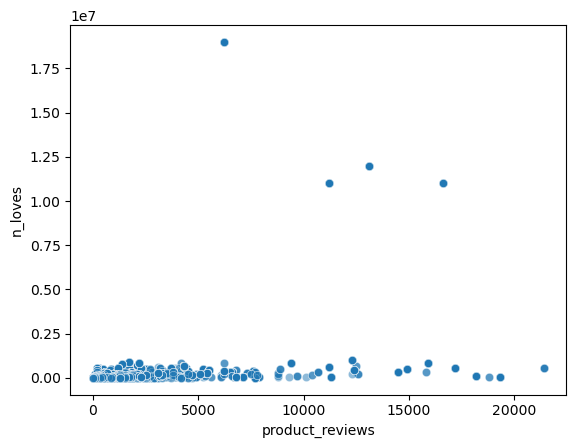

array(['soft pinch liquid blush',
       'lip sleeping mask intense hydration with vitamin c',
       'radiant creamy concealer', 'cream lip stain liquid lipstick'],
      dtype=object)

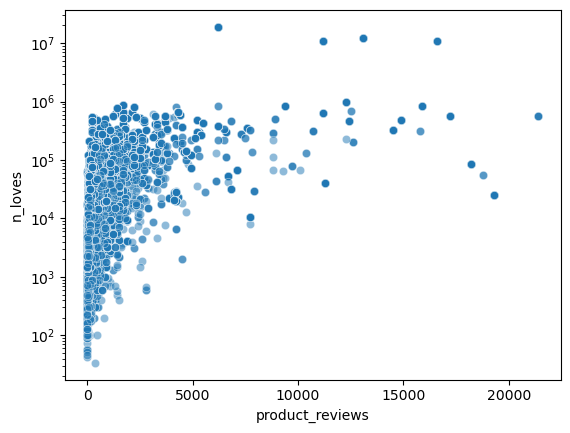

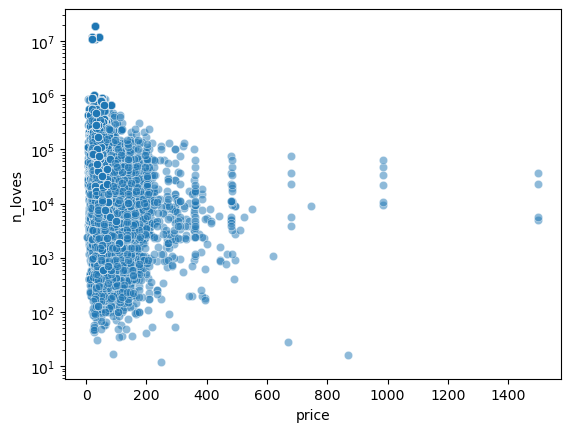

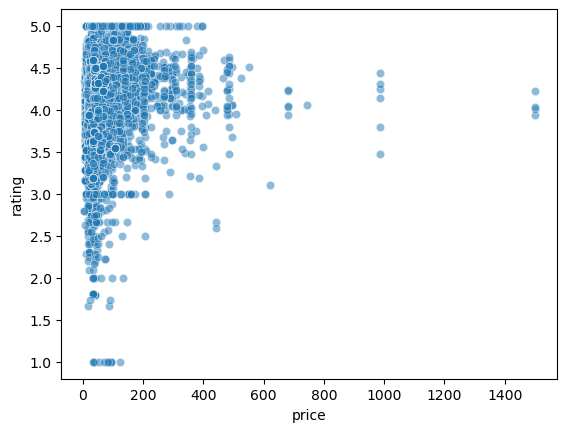

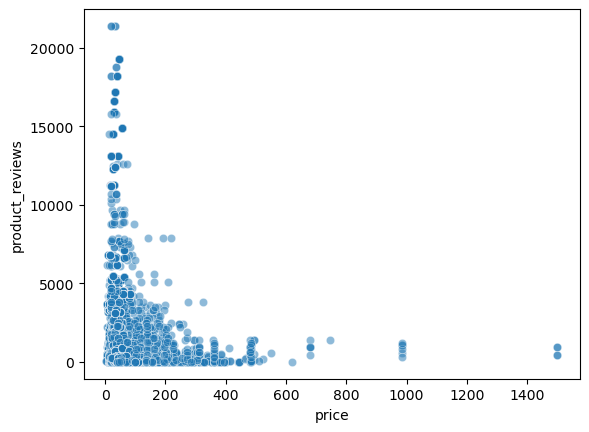

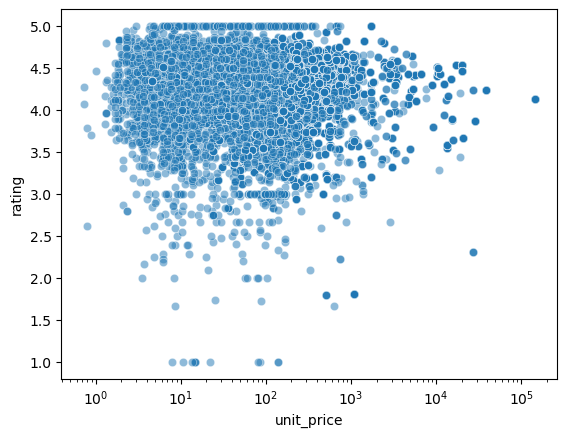

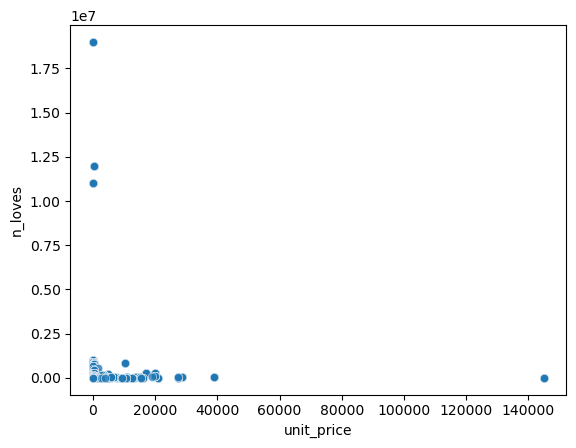

In [58]:
# df_products
# EDA - what is the distribution of product reviews
# scatter reviews v ratings

sns.scatterplot(data=df_products, x="product_reviews", y="rating", alpha=0.5)
plt.show()
# how many products have no reviews?
# interesting outliers - looked at reviews, truly bad
display(df_products[(df_products['product_reviews']>4000) & (df_products['rating']<3.2)])


# scattr review v loves
# the handful of outliers are so interesting
# was there a promotion to add these to loves list?
sns.scatterplot(data=df_products, x="product_reviews", y="n_loves", alpha=0.5)
plt.show()
display(df_products[(df_products['n_loves']>1500000)]['product_name'].unique())
sns.scatterplot(data=df_products, x="product_reviews", y="n_loves", alpha=0.5)
plt.yscale('log')
plt.show()
# scatter n loves v price 
sns.scatterplot(data=df_products, x="price", y="n_loves", alpha=0.5)
plt.yscale('log')
plt.show()


sns.scatterplot(data=df_products, x="price", y="rating", alpha=0.5)
plt.show()

sns.scatterplot(data=df_products, x="price", y="product_reviews", alpha=0.5)
plt.show()

sns.scatterplot(data=df_products[df_products['unit_a']=='oz'], x="unit_price", y="rating", alpha=0.5)
plt.xscale('log')
plt.show()

sns.scatterplot(data=df_products[df_products['unit_a']=='oz'], x="unit_price", y="n_loves", alpha=0.5)
plt.show()

## Swatch group comparisons

In [60]:
df = df_products[df_products['lvl_2_cat']=='Mascara'].groupby(['brand_name','product_name','swatch_group','unit_a'], as_index=False).agg({
    'internal_product_id':'count',
    'unit_price':'mean',
    'price':'mean',
    'amount_a':'mean'
})


In [61]:
df = df[df.groupby(['brand_name','product_name','unit_a'])['swatch_group'].transform(lambda x : x.nunique()>1)]

df['full_product'] = df['brand_name']+' '+ df['product_name']
df = df.pivot(index='full_product', columns='swatch_group', values='unit_price') # ['unit_a',]
df = df.reset_index()

In [62]:
df = df[['full_product','mini size','standard size']]

In [63]:
df = df.set_index('full_product').stack('swatch_group').reset_index().rename(columns={0:'unit_price'})

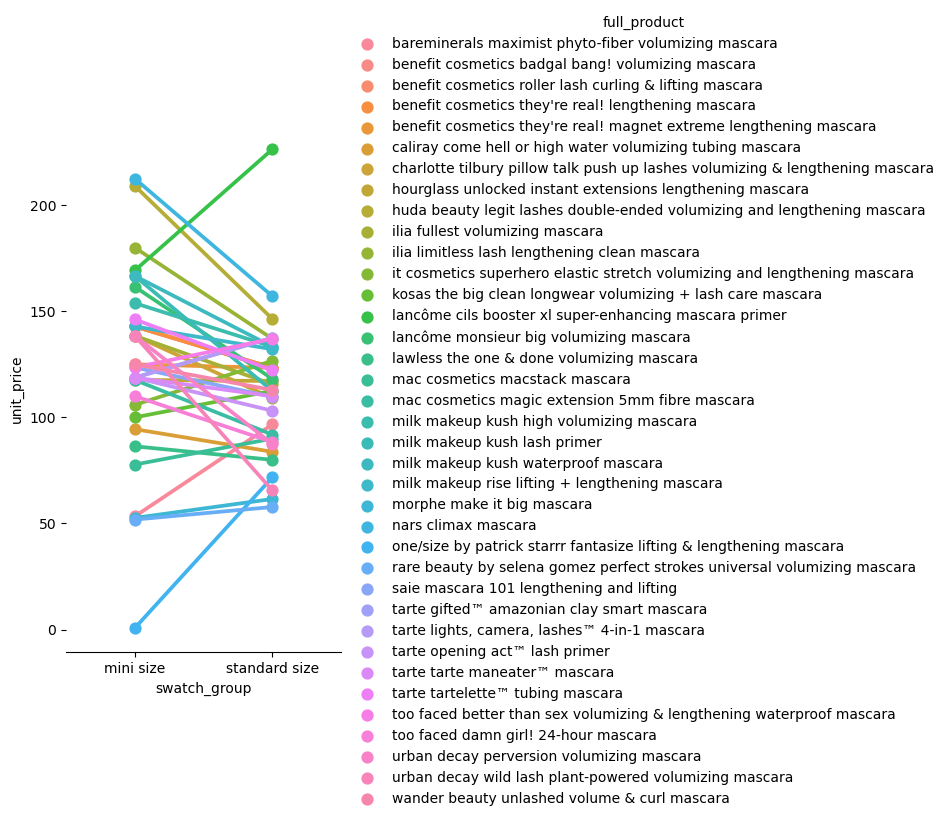

In [64]:

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=df, x="swatch_group", y="unit_price", hue="full_product",
    capsize=.2, #palette="YlGnBu_d",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

In [65]:
# in bare minerals - mini size == standard

In [66]:
issue_brands = ['Tom Ford', 'tarte', 'Moroccanoil', 'Dior', 'Anastasia Beverly Hills']
prods = ['clinique']
# url = 'https://www.sephora.com/ca/en/product/charlotte-tilbury-airbrush-flawless-setting-spray-P461147?skuId=2368439&icid2=products%20grid:p461147:product'

# url = 'https://www.sephora.com/ca/en/product/ambient-lighting-blush-collection-P384963?skuId=1581321&icid2=products%20grid:p384963:product'
# lots of options all same size
# url = "https://www.sephora.com/ca/en/product/saie-glowy-super-skin-lightweight-hydrobounce-serum-foundation-P504907?icid2=new_ca_skugrid_ufe:p504907:product"
# ran into issue getting product name
# url = "https://www.sephora.com/ca/en/product/book-personal-travel-spray-P501954?icid2=homepage_productlist_brandnewadditions_ca_rwd_092022"
# value set works
# url = 'https://www.sephora.com/ca/en/product/laneige-midnight-to-morning-hydration-set-P504208?skuId=2639557&icid2=products%20grid:p504208:product'
# hair brush with no ingredients
# url = 'https://www.sephora.com/ca/en/product/sephora-collection-scalp-massager-P472069?skuId=2414555&icid2=products%20grid:p472069:product'
# new prod
# url = 'https://www.sephora.com/ca/en/product/gxve-by-gwen-stefani-check-my-glow-platinum-glow-highlighter-P505655?icid2=new_ca_skugrid_ufe:p505655:product'
# sale prod
# url = 'https://www.sephora.com/ca/en/product/green-microalgae-retinol-regenerating-serum-P506077?skuId=2672301&icid2=products%20grid:p506077:product'
# no reviews yet or ratings

# broken page https://www.sephora.com/ca/en/product/beautyblender-bronze-besties-P505630?skuId=2662559&icid2=products


with open(data_dir+'brand_data.json') as file:
    brand_data = json.loads(file.read())

NameError: name 'data_dir' is not defined